In [42]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2
%cd ../../src

from torchvision import models
from torch.nn.modules import Softmax
from matplotlib import pyplot as plt
import numpy as np
import torch

from vinsight.visualization import *

if torch.cuda.is_available and torch.cuda.device_count() > 0:
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[Errno 2] No such file or directory: '../../src'
/home/fabian/Projects/interpretability-framework/src


In [5]:
alexnet = models.alexnet(pretrained=True)

def show(img):
    plt.imshow(img.numpy())
    plt.show()
    
def show_norm(img):
    reg_img = img - img.min()
    reg_img = reg_img / reg_img.max()
    show(reg_img)

# 1. Channel-wise regularization comparisons
Here we will look at the effect of different regularizers.
## 1.1 No regularization
Per default, some weight decay is used, which can be seen as l1-reg. Hence we set it to zero in most of the following experiments.

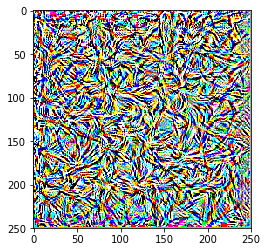

In [6]:
show(PixelActivation(
    alexnet.features[:9],
    NeuronSelector(ChannelSplit(), [1]),
    weight_decay=0
).visualize())

## 1.2 Weight decay (l1)
Less relevant parts of the image are set to zero.

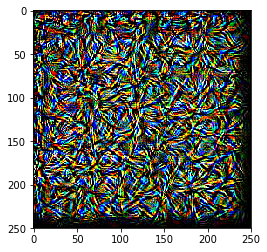

In [11]:
show(PixelActivation(
    alexnet.features[:9],
    NeuronSelector(ChannelSplit(), [1]),
    weight_decay=5e-6
).visualize())

## 1.3 Blur Filter
Performs simple blurring after each step. Has the issue that edges are not preserved.

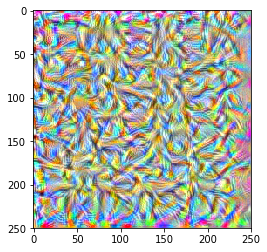

In [12]:
show(PixelActivation(
    alexnet.features[:9],
    NeuronSelector(ChannelSplit(), [1]),
    weight_decay=0,
    transform = BlurTrans()
).visualize())

## 1.4 Bilateral Filter
Like blur, but preserves edges.

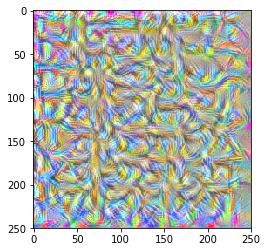

In [14]:
show(PixelActivation(
    alexnet.features[:9],
    NeuronSelector(ChannelSplit(), [1]),
    weight_decay=0,
    transform=BilateralTrans()
).visualize())

## 1.5 Random robustness transformations
Apply random translation, rotation, and scaling after each iteration

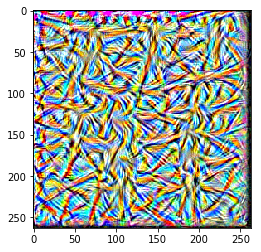

In [15]:
show(PixelActivation(
    alexnet.features[:9],
    NeuronSelector(ChannelSplit(), [1]),
    weight_decay=0,
    transform=RandomTrans()
).visualize())

## 1.6 Resizing transform
After each iteration, scale the image up. This has the advantage that low-frequency patterns can be picked up better.

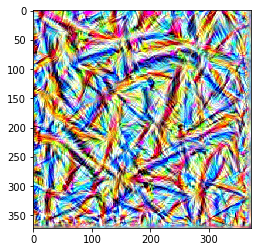

In [20]:
show(PixelActivation(
    alexnet.features[:9],
    NeuronSelector(ChannelSplit(), [1]),
    weight_decay=0,
    transform=ResizeTrans(),
    init_size=50
).visualize())

## 1.7 Total Variation Regularizer
Add total variation to the loss, which punishes difference in adjacent pixels.

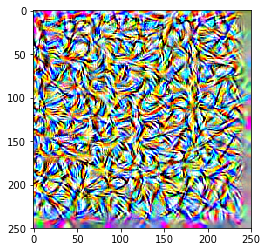

In [22]:
show(PixelActivation(
    alexnet.features[:9],
    NeuronSelector(ChannelSplit(), [1]),
    weight_decay=0,
    reg=TVReg(coefficient=0.5)
).visualize())

# 2. Combining regularizers
 - weight decay to gray out irrelevant parts
 - blur (or biliteral filter) for penalizing high-frequency noise
 - resizing to capture low-frequency patterns
 - random transformations to get robust image
 - total variation to get more natural looking image

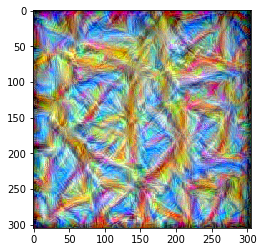

In [30]:
show(PixelActivation(
    alexnet.features[:9],
    NeuronSelector(ChannelSplit(), [1]),
    transform=RandomTrans()+BlurTrans()+ResizeTrans(),
    weight_decay=3e-7,
    init_size=50,
    reg=TVReg()
).visualize())

# 3. Spatial and Individual Splits
## 3.1 Spatial
Note how some parts of the image do not have any influence on the gradient, since the convolutions have not yet progressed as far.

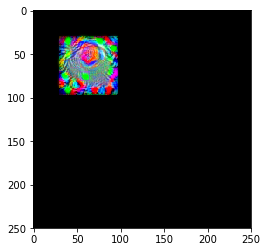

In [39]:
show(PixelActivation(
    alexnet.features[:6],
    NeuronSelector(SpatialSplit(), [3, 3]),
    transform=BlurTrans(),
    weight_decay=1e-6,
).visualize())

# 3.2 Individual Neurons

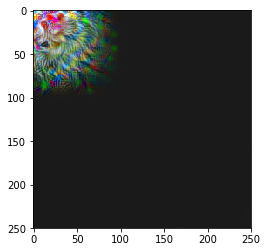

In [41]:
show(PixelActivation(
    alexnet.features[:11],
    NeuronSelector(NeuronSplit(), [0, 0, 0]),
    transform=BlurTrans(),
).visualize())

# 4. Class visualization
Try to visualize class 783 (Screw)

TODO experiment a bit (using a GPU)

In [ ]:
res=PixelActivation(
    [alexnet]+[Softmax(dim=1)],
    NeuronSelector(NeuronSplit(), [783]),
    transform=RandomTrans()+BilateralTrans()+ResizeTrans(),
    weight_decay=1e-8,
    opt_n=100,
    iter_n=14,
    reg=TVReg(coefficient=0.01)
).visualize()

In [ ]:
show(res)
show_norm(res)